In [1]:
# Install Prophet (only if not already installed)
!pip install prophet --quiet

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Others
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Replace the path below with your actual file path
data_path = '/content/IPC_IPC.csv'

# Load the dataset
df = pd.read_csv(data_path)

# Preview the dataset
df.head()


,STRUCTURE,STRUCTURE_ID,ACTION,FREQ,FREQ_LABEL,REF_AREA,REF_AREA_LABEL,INDICATOR,INDICATOR_LABEL,SEX,...,UNIT_MULT,UNIT_MULT_LABEL,UNIT_TYPE,UNIT_TYPE_LABEL,TIME_FORMAT,TIME_FORMAT_LABEL,OBS_STATUS,OBS_STATUS_LABEL,OBS_CONF,OBS_CONF_LABEL
0,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,BDI,Burundi,IPC_IPC_P3PLUS,People in Phase 3 food insecurity or above,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
1,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,CAF,Central African Republic,IPC_IPC_P3PLUS,People in Phase 3 food insecurity or above,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
2,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,GTM,Guatemala,IPC_IPC_P3PLUS,People in Phase 3 food insecurity or above,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
3,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,HTI,Haiti,IPC_IPC_P3PLUS,People in Phase 3 food insecurity or above,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
4,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,SWZ,Eswatini,IPC_IPC_P3PLUS,People in Phase 3 food insecurity or above,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public


In [3]:
# Overview of the data
df.info()

# Check missing values
print("\nMissing values:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   STRUCTURE               5832 non-null   object 
 1   STRUCTURE_ID            5832 non-null   object 
 2   ACTION                  5832 non-null   object 
 3   FREQ                    5832 non-null   object 
 4   FREQ_LABEL              5832 non-null   object 
 5   REF_AREA                5832 non-null   object 
 6   REF_AREA_LABEL          5832 non-null   object 
 7   INDICATOR               5832 non-null   object 
 8   INDICATOR_LABEL         5832 non-null   object 
 9   SEX                     5832 non-null   object 
 10  SEX_LABEL               5832 non-null   object 
 11  AGE                     5832 non-null   object 
 12  AGE_LABEL               5832 non-null   object 
 13  URBANISATION            5832 non-null   object 
 14  URBANISATION_LABEL      5832 non-null   

In [4]:
# Step 1: Select relevant columns
df_clean = df[['REF_AREA_LABEL', 'TIME_PERIOD', 'OBS_VALUE']].copy()

# Step 2: Rename columns for simplicity
df_clean.columns = ['country', 'date', 'ipc_p3plus']

# Step 3: Convert date column to datetime
df_clean['date'] = pd.to_datetime(df_clean['date'], format='%Y-%m')

# Step 4: Drop rows with missing ipc values
df_clean = df_clean.dropna(subset=['ipc_p3plus'])

# Step 5: Sort data
df_clean = df_clean.sort_values(by=['country', 'date']).reset_index(drop=True)

# Step 6: Preview cleaned data
df_clean.head()


,country,date,ipc_p3plus
0,Afghanistan,2017-05-01,762742.0
1,Afghanistan,2017-05-01,26.0
2,Afghanistan,2017-05-01,1085103.0
3,Afghanistan,2017-05-01,36.0
4,Afghanistan,2017-05-01,1143324.0


In [5]:
# Group by country and date, summing ipc_p3plus values
df_agg = df_clean.groupby(['country', 'date'], as_index=False)['ipc_p3plus'].sum()

# Display the first 10 rows
df_agg.head(10)


,country,date,ipc_p3plus
0,Afghanistan,2017-05-01,3754037.0
1,Afghanistan,2017-09-01,36609896.0
2,Afghanistan,2018-01-01,5228956.0
3,Afghanistan,2018-09-01,32405613.0
4,Afghanistan,2019-09-01,40957934.0
5,Afghanistan,2020-04-01,41583120.0
6,Afghanistan,2020-09-01,42539569.0
7,Afghanistan,2021-03-01,42329236.0
8,Afghanistan,2021-10-01,59256461.0
9,Afghanistan,2022-03-01,61377613.0


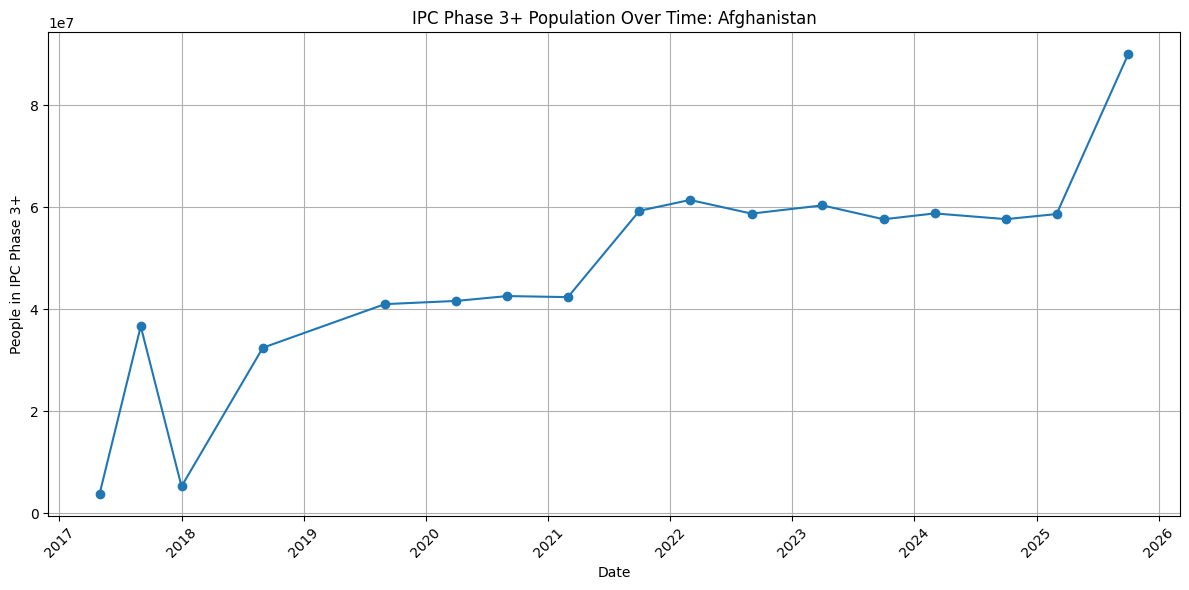

In [ ]:
# Filter data for one country, e.g., Afghanistan
country_name = 'Afghanistan'
df_country = df_agg[df_agg['country'] == country_name]

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_country['date'], df_country['ipc_p3plus'], marker='o')
plt.title(f"IPC Phase 3+ Population Over Time: {country_name}")
plt.xlabel("Date")
plt.ylabel("People in IPC Phase 3+")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Check types and value examples
print(df_agg.dtypes)

# Check for any non-numeric examples
non_numeric = df_agg[~df_agg['ipc_p3plus'].apply(lambda x: isinstance(x, (int, float)))]
print("Non-numeric rows:", non_numeric.shape[0])
print(non_numeric.head())


country               object
date          datetime64[ns]
ipc_p3plus           float64
dtype: object
Non-numeric rows: 0
Empty DataFrame
Columns: [country, date, ipc_p3plus]
Index: []


In [7]:
# Count observations per country
obs_counts = df_agg.groupby('country').size().sort_values()

# Show countries with fewest data points
print(obs_counts.head(20))


country
Ecuador               1
South Africa          1
Timor-Leste           2
Angola                2
Liberia               3
Bangladesh            3
Dominican Republic    3
Cabo Verde            4
Ethiopia              4
Zimbabwe              4
El Salvador           4
Djibouti              5
Lebanon               5
Sudan                 6
Gambia, The           6
West Bank and Gaza    6
Tanzania              6
Niger                 8
Namibia               8
Honduras              8
dtype: int64
